# Comprehensive ML Analysis Suite for Evolutionary Trait Dependencies

This notebook implements a comprehensive machine learning pipeline to analyze evolutionary trait dependencies in fly species data. The analysis accelerates biological research by automating complex pattern recognition that would traditionally take weeks to complete manually.

## Objectives:
1. **Unsupervised Learning**: Identify distinct evolutionary trait dependencies using dimensionality reduction and clustering
2. **Supervised Learning**: Build predictive models for trait relationships
3. **Statistical Validation**: Use advanced statistical methods to validate evolutionary hypotheses

## Models Implemented:
- **Unsupervised**: PCA, UMAP, k-NN clustering, Gaussian Mixture Models (GMM), Decision Trees (for feature importance)
- **Supervised**: SVM, Multivariate Regression, Decision Trees, Time Series Analysis
- **Statistical Validation**: LASSO Regression, Naive Bayes Classification, Correlation Tests


In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.mixture import GaussianMixture
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import (accuracy_score, r2_score, mean_squared_error, 
                           classification_report, confusion_matrix, 
                           silhouette_score, adjusted_rand_score)
from sklearn.multiclass import OneVsRestClassifier
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Try importing UMAP, use PCA if not available
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not available, will use t-SNE as alternative")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("All libraries imported successfully!")
print(f"UMAP available: {HAS_UMAP}")


All libraries imported successfully!
UMAP available: True


In [2]:
# Load and prepare data
print("Loading dataset...")
df = pd.read_csv("../data/master.dataset.final.v2.csv")

# Clean data
df = df.dropna(axis=1, how='all').dropna(axis=0, how='all')

# Get numeric columns (excluding standard error columns)
numeric_cols = df.select_dtypes(include=[np.number]).columns
trait_cols = [col for col in numeric_cols if not col.endswith('_se')]

# Prepare feature matrix
X = df[trait_cols].copy()
X = X.fillna(X.mean())  # Fill missing values with mean

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Get species names
species_names = df['Species'].values if 'Species' in df.columns else df.index.values

print(f"Dataset shape: {df.shape}")
print(f"Number of species: {len(species_names)}")
print(f"Number of traits: {len(trait_cols)}")
print(f"Feature matrix shape: {X_scaled.shape}")

# Display summary statistics
print("\nTrait summary:")
print(f"Mean values range: [{X_scaled.mean(axis=0).min():.3f}, {X_scaled.mean(axis=0).max():.3f}]")
print(f"Std values range: [{X_scaled.std(axis=0).min():.3f}, {X_scaled.std(axis=0).max():.3f}]")


Loading dataset...
Dataset shape: (149, 104)
Number of species: 149
Number of traits: 70
Feature matrix shape: (149, 70)

Trait summary:
Mean values range: [-0.000, 0.000]
Std values range: [1.000, 1.000]


## Part 1: Unsupervised Learning - Identifying Evolutionary Trait Dependencies

We'll use dimensionality reduction and clustering techniques to discover distinct evolutionary trait dependencies without labeled data.


### 1.1 Principal Component Analysis (PCA)

PCA identifies the principal axes of variation in the trait data, revealing which traits contribute most to evolutionary diversity.


Performing PCA analysis...


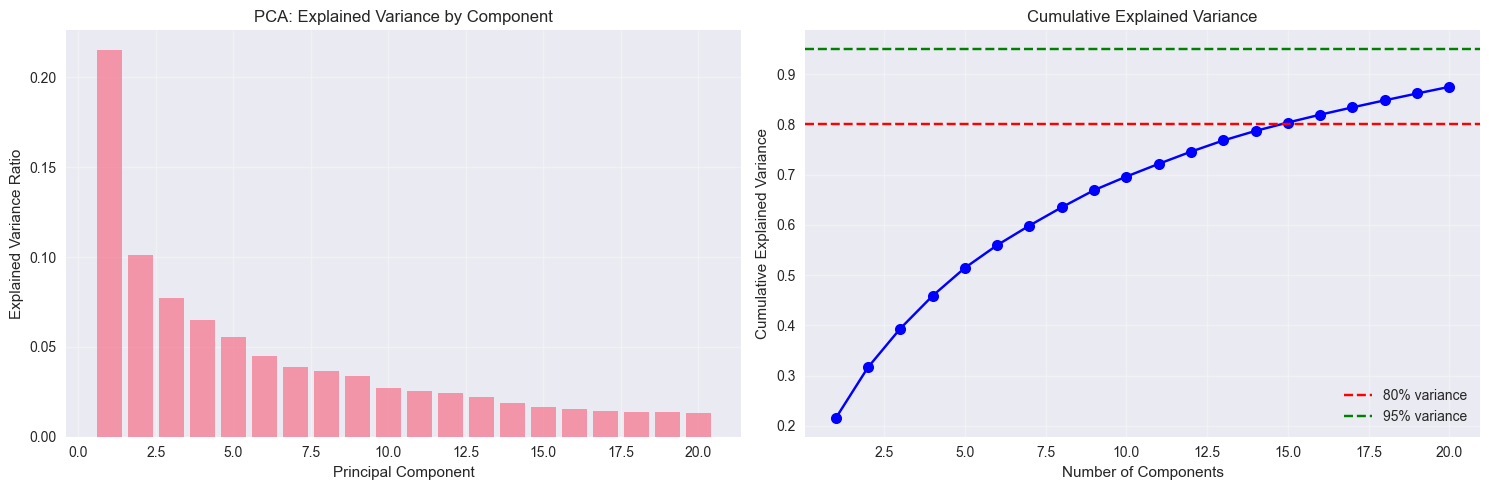

IndexError: index 0 is out of bounds for axis 0 with size 0

In [3]:
# Perform PCA
print("Performing PCA analysis...")
pca = PCA(n_components=min(20, X_scaled.shape[1]))
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Explained variance plot
axes[0].bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7)
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA: Explained Variance by Component')
axes[0].grid(True, alpha=0.3)

# Cumulative variance plot
axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-', markersize=8)
axes[1].axhline(y=0.8, color='r', linestyle='--', label='80% variance')
axes[1].axhline(y=0.95, color='g', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('Cumulative Explained Variance')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
n_components_80 = np.where(cumulative_variance >= 0.8)[0][0] + 1
n_components_95 = np.where(cumulative_variance >= 0.95)[0][0] + 1

print(f"Number of components explaining 80% variance: {n_components_80}")
print(f"Number of components explaining 95% variance: {n_components_95}")
print(f"First 5 components explain {cumulative_variance[4]:.2%} of variance")

# Visualize first 2 principal components
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.6, s=50, c=range(len(X_pca)), cmap='viridis')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.title('PCA: First Two Principal Components')
plt.colorbar(scatter, label='Species Index')
plt.grid(True, alpha=0.3)
plt.show()

# Identify most important traits for first few PCs
print("\nTop 5 traits contributing to PC1:")
pc1_contributions = pd.Series(pca.components_[0], index=trait_cols).abs().sort_values(ascending=False)
print(pc1_contributions.head(5))

print("\nTop 5 traits contributing to PC2:")
pc2_contributions = pd.Series(pca.components_[1], index=trait_cols).abs().sort_values(ascending=False)
print(pc2_contributions.head(5))


### 1.2 UMAP (Uniform Manifold Approximation and Projection)

UMAP preserves both local and global structure in high-dimensional data, revealing subtle evolutionary relationships.


Performing UMAP analysis...


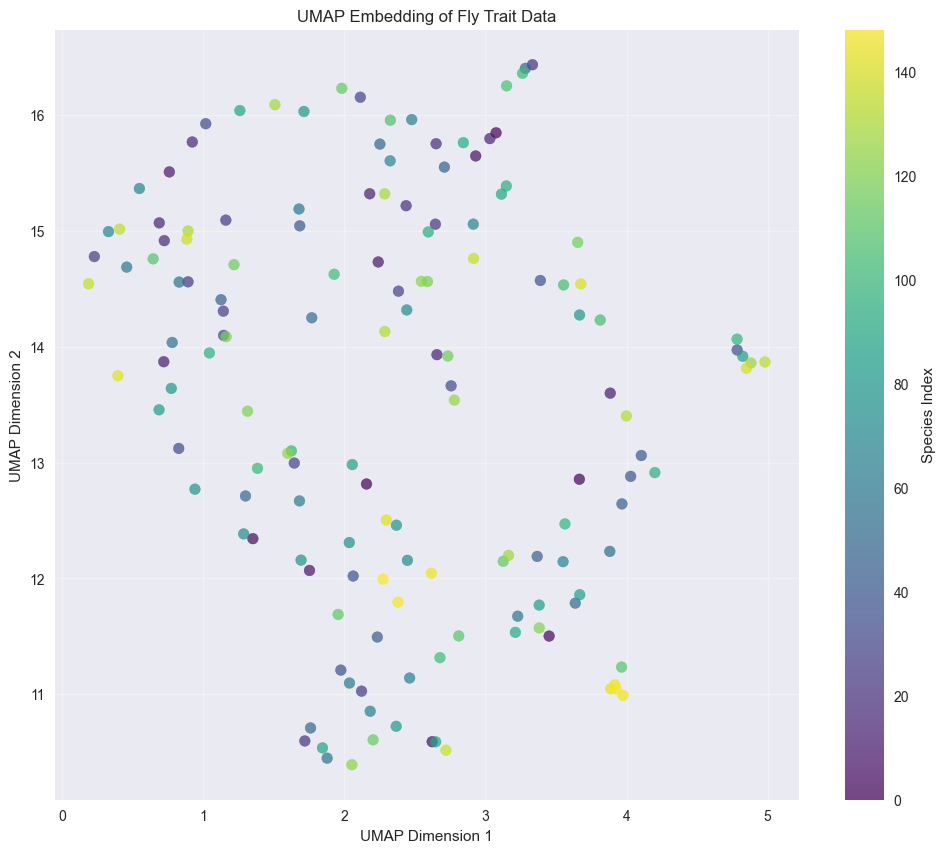

UMAP embedding shape: (149, 2)
UMAP preserved local structure with 15 neighbors
3D UMAP embedding created: (149, 3)


In [4]:
# Perform UMAP dimensionality reduction
print("Performing UMAP analysis...")

if HAS_UMAP:
    # Create UMAP reducer
    reducer = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=2,
        metric='euclidean',
        random_state=42
    )
    
    # Fit and transform
    X_umap = reducer.fit_transform(X_scaled)
    
    # Visualize UMAP embedding
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.7, s=60, 
                         c=range(len(X_umap)), cmap='viridis')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.title('UMAP Embedding of Fly Trait Data')
    plt.colorbar(scatter, label='Species Index')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"UMAP embedding shape: {X_umap.shape}")
    print(f"UMAP preserved local structure with {reducer.n_neighbors} neighbors")
    
    # Also create 3D UMAP for better visualization
    reducer_3d = umap.UMAP(
        n_neighbors=15,
        min_dist=0.1,
        n_components=3,
        metric='euclidean',
        random_state=42
    )
    X_umap_3d = reducer_3d.fit_transform(X_scaled)
    print(f"3D UMAP embedding created: {X_umap_3d.shape}")
    
else:
    # Fallback to t-SNE if UMAP not available
    print("Using t-SNE as UMAP alternative...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_umap = tsne.fit_transform(X_scaled)
    
    plt.figure(figsize=(12, 10))
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], alpha=0.7, s=60, 
                         c=range(len(X_umap)), cmap='viridis')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.title('t-SNE Embedding of Fly Trait Data (UMAP Alternative)')
    plt.colorbar(scatter, label='Species Index')
    plt.grid(True, alpha=0.3)
    plt.show()


### 1.3 k-NN Clustering

k-NN clustering identifies species groups with similar trait profiles, revealing evolutionary syndromes.


Performing k-NN clustering analysis...


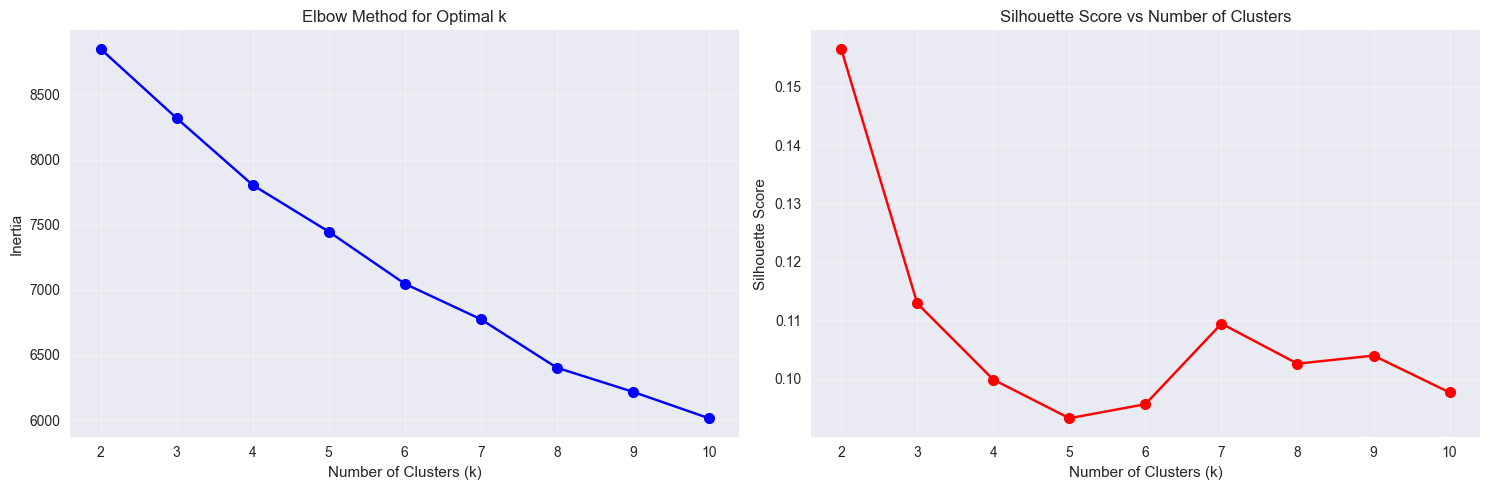

Optimal number of clusters: 2 (silhouette score: 0.157)


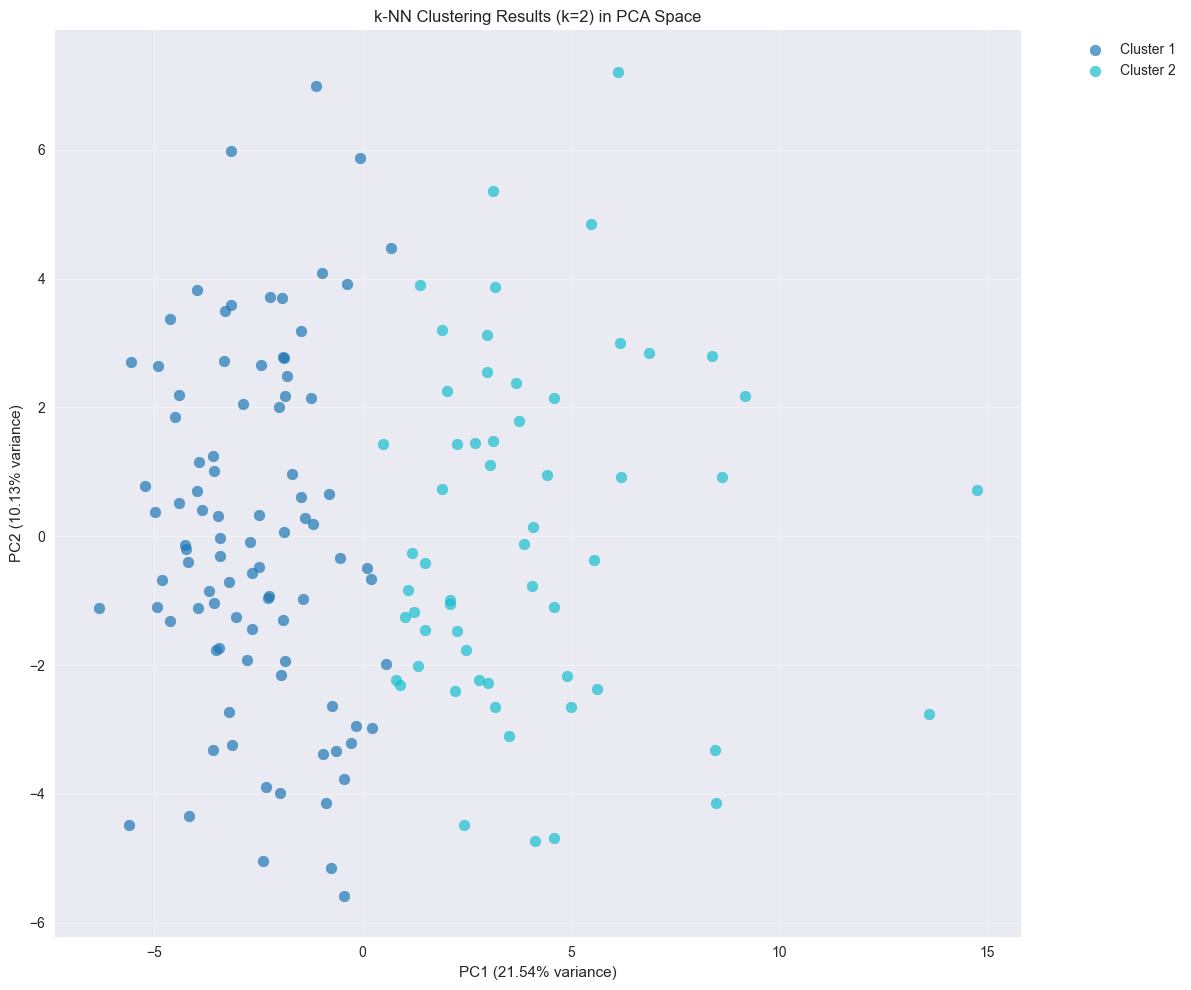


Cluster Analysis:
----------------------------------------
Cluster 1: 91 species
  Example species: ['C_procnemis', 'D_acutilabella', 'D_affinis']
Cluster 2: 58 species
  Example species: ['D_albomicans', 'D_aldrichi', 'D_americana']


In [5]:
# k-NN Clustering Analysis
print("Performing k-NN clustering analysis...")

# Use k-NN to find optimal number of clusters
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

# Find optimal k using elbow method and silhouette score
silhouette_scores = []
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    inertias.append(kmeans.inertia_)

# Plot elbow curve and silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Elbow curve
axes[0].plot(K_range, inertias, 'bo-', markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(K_range, silhouette_scores, 'ro-', markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs Number of Clusters')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Find optimal k
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k} (silhouette score: {max(silhouette_scores):.3f})")

# Perform k-means clustering with optimal k
kmeans_optimal = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
cluster_labels = kmeans_optimal.fit_predict(X_scaled)

# Visualize clusters in PCA space
plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, optimal_k))
for i in range(optimal_k):
    mask = cluster_labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[i]], label=f'Cluster {i+1}', alpha=0.7, s=60)

plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.title(f'k-NN Clustering Results (k={optimal_k}) in PCA Space')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze cluster characteristics
print("\nCluster Analysis:")
print("-" * 40)
for i in range(optimal_k):
    cluster_size = np.sum(cluster_labels == i)
    cluster_indices = np.where(cluster_labels == i)[0]
    print(f"Cluster {i+1}: {cluster_size} species")
    if cluster_size > 0:
        print(f"  Example species: {species_names[cluster_indices[:3]].tolist()}")


### 1.4 Gaussian Mixture Models (GMM)

GMM identifies clusters by modeling trait distributions as mixtures of Gaussian components, capturing overlapping evolutionary strategies.


Performing GMM clustering analysis...
Optimal number of GMM components (BIC): 2


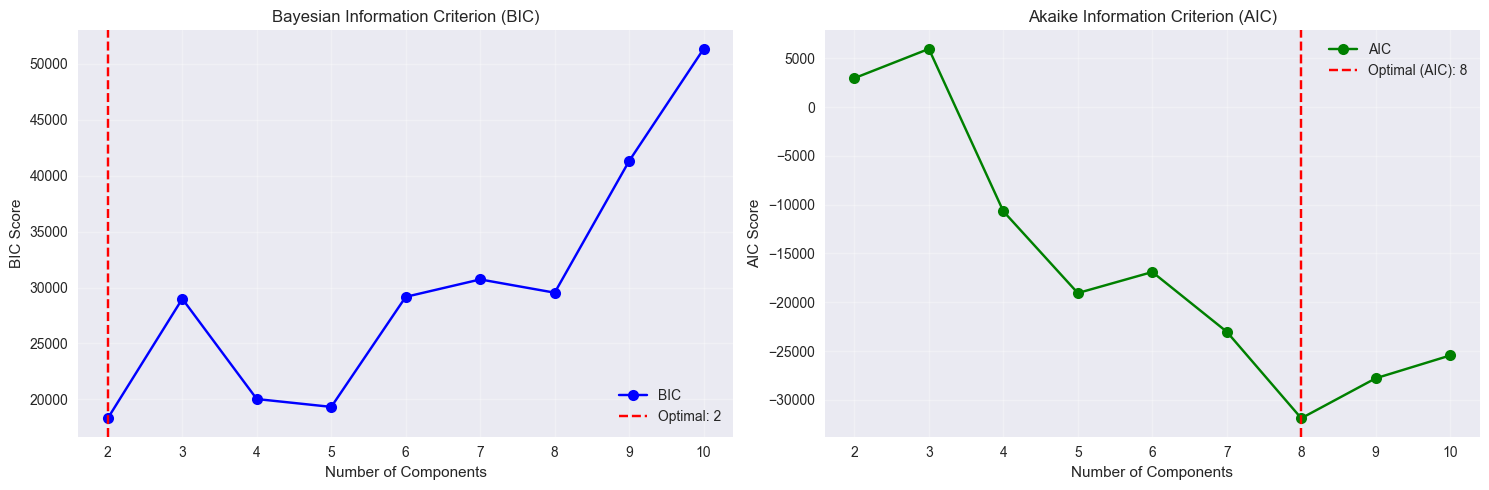

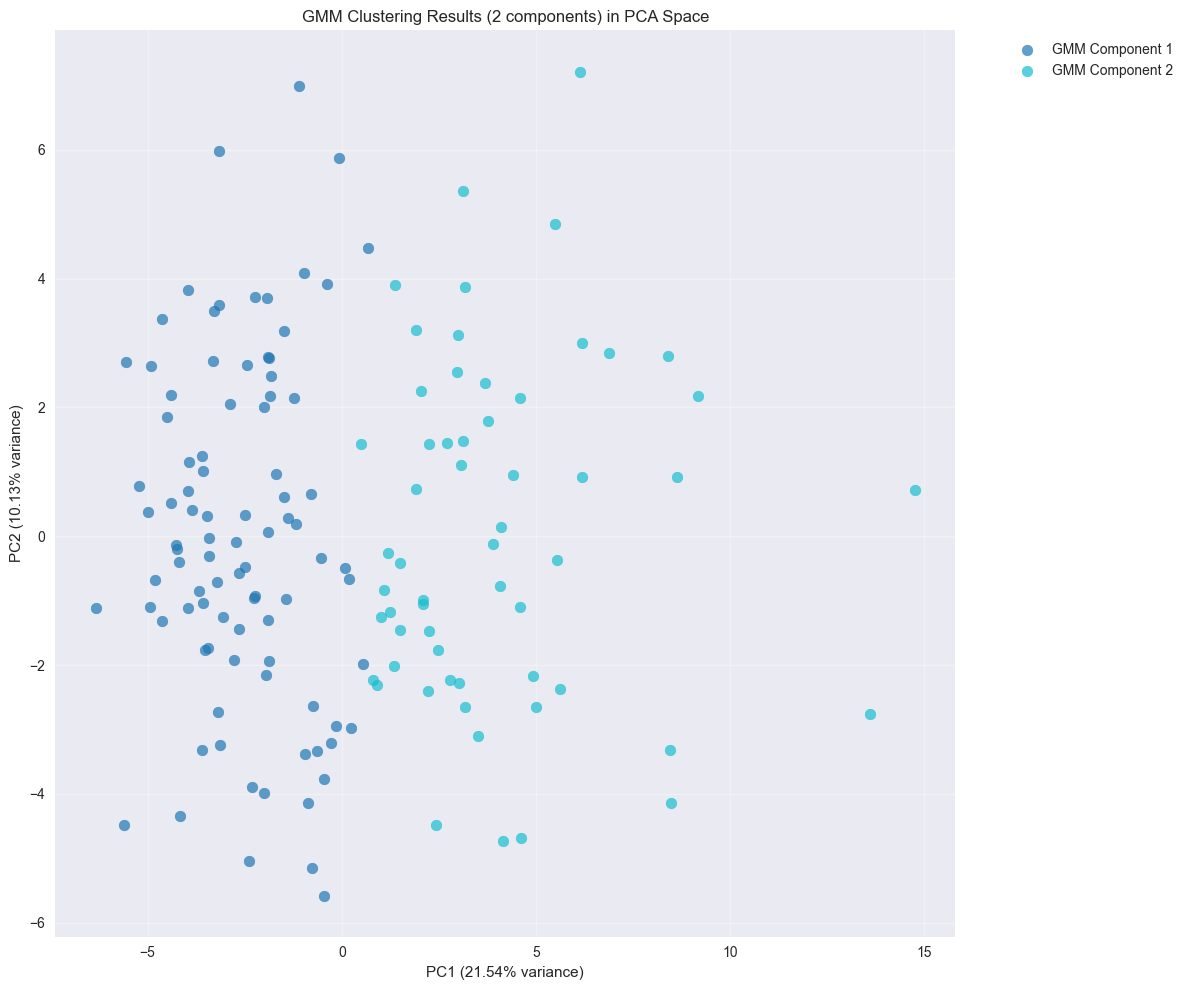


GMM Component Analysis:
----------------------------------------
Component 1: 91 species (weight: 0.611)
  Example species: ['C_procnemis', 'D_acutilabella', 'D_affinis']
Component 2: 58 species (weight: 0.389)
  Example species: ['D_albomicans', 'D_aldrichi', 'D_americana']


In [6]:
# Gaussian Mixture Models (GMM)
print("Performing GMM clustering analysis...")

# Find optimal number of components using BIC and AIC
n_components_range = range(2, 11)
bic_scores = []
aic_scores = []
gmm_models = []

for n_comp in n_components_range:
    gmm = GaussianMixture(n_components=n_comp, random_state=42, max_iter=100)
    gmm.fit(X_scaled)
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))
    gmm_models.append(gmm)

# Find optimal number of components
optimal_n_components = n_components_range[np.argmin(bic_scores)]
print(f"Optimal number of GMM components (BIC): {optimal_n_components}")

# Fit final GMM model
gmm_optimal = GaussianMixture(n_components=optimal_n_components, random_state=42, max_iter=100)
gmm_optimal.fit(X_scaled)
gmm_labels = gmm_optimal.predict(X_scaled)
gmm_proba = gmm_optimal.predict_proba(X_scaled)

# Plot BIC and AIC scores
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(n_components_range, bic_scores, 'bo-', markersize=8, label='BIC')
axes[0].axvline(x=optimal_n_components, color='r', linestyle='--', label=f'Optimal: {optimal_n_components}')
axes[0].set_xlabel('Number of Components')
axes[0].set_ylabel('BIC Score')
axes[0].set_title('Bayesian Information Criterion (BIC)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(n_components_range, aic_scores, 'go-', markersize=8, label='AIC')
optimal_aic = n_components_range[np.argmin(aic_scores)]
axes[1].axvline(x=optimal_aic, color='r', linestyle='--', label=f'Optimal (AIC): {optimal_aic}')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('AIC Score')
axes[1].set_title('Akaike Information Criterion (AIC)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Visualize GMM clusters in PCA space
plt.figure(figsize=(12, 10))
colors = plt.cm.tab10(np.linspace(0, 1, optimal_n_components))
for i in range(optimal_n_components):
    mask = gmm_labels == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
               c=[colors[i]], label=f'GMM Component {i+1}', alpha=0.7, s=60)

plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.title(f'GMM Clustering Results ({optimal_n_components} components) in PCA Space')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Analyze GMM component characteristics
print("\nGMM Component Analysis:")
print("-" * 40)
for i in range(optimal_n_components):
    component_size = np.sum(gmm_labels == i)
    component_indices = np.where(gmm_labels == i)[0]
    component_weight = gmm_optimal.weights_[i]
    print(f"Component {i+1}: {component_size} species (weight: {component_weight:.3f})")
    if component_size > 0:
        print(f"  Example species: {species_names[component_indices[:3]].tolist()}")


## Part 2: Supervised Learning - Predicting Trait Relationships

We'll build predictive models to understand trait dependencies and relationships.


### 2.1 Support Vector Machines (SVM)

SVM models can classify species into evolutionary syndromes or predict continuous trait values.


Performing SVM analysis...

SVM Classification (species syndrome classification):
SVM Classification Accuracy: 0.9333

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.94        27
           1       0.89      0.94      0.92        18

    accuracy                           0.93        45
   macro avg       0.93      0.94      0.93        45
weighted avg       0.93      0.93      0.93        45



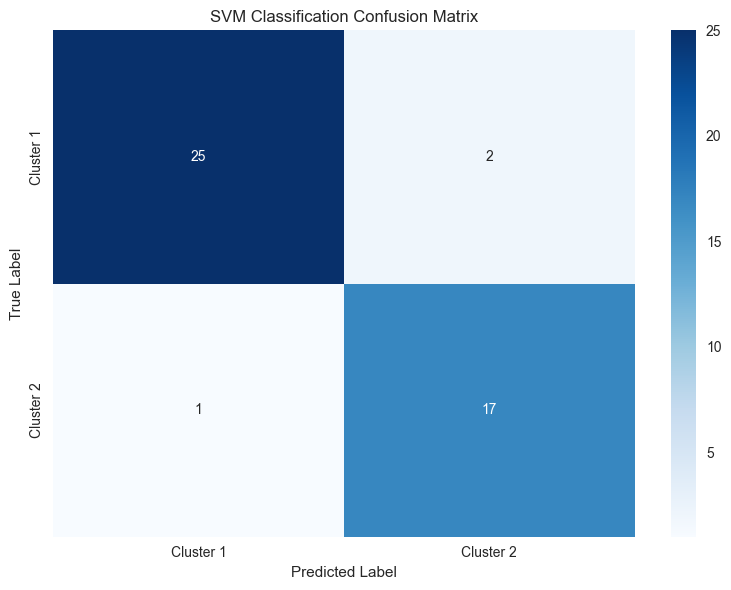


SVM Regression (predicting th.len.m):
SVM Regression R²: 0.6999
SVM Regression RMSE: 0.6515


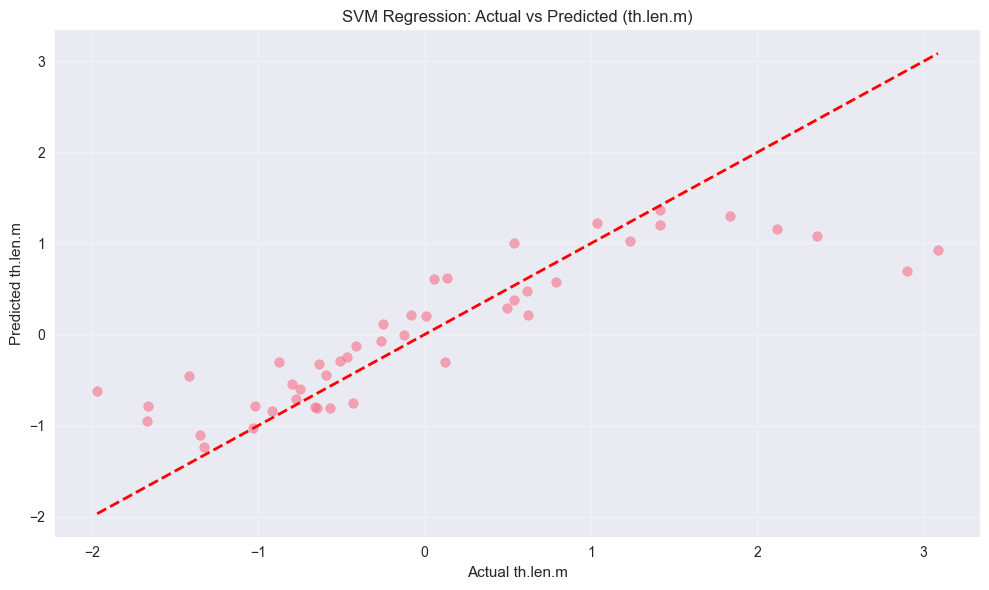

In [7]:
# SVM Analysis - Classification and Regression
print("Performing SVM analysis...")

# SVM for Classification (using cluster labels as targets)
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, cluster_labels, test_size=0.3, random_state=42, stratify=cluster_labels
)

# Train SVM classifier
print("\nSVM Classification (species syndrome classification):")
svm_classifier = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42)
svm_classifier.fit(X_train, y_train)

# Predictions
y_pred_svm = svm_classifier.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"SVM Classification Accuracy: {accuracy_svm:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_svm))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
           xticklabels=[f'Cluster {i+1}' for i in range(optimal_k)],
           yticklabels=[f'Cluster {i+1}' for i in range(optimal_k)])
plt.title('SVM Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# SVM for Regression (predicting a continuous trait)
# Select a trait to predict (e.g., first trait after removing SE columns)
target_trait_idx = 0
target_trait_name = trait_cols[target_trait_idx]
y_regression = X_scaled[:, target_trait_idx]
X_regression = np.delete(X_scaled, target_trait_idx, axis=1)

# Split for regression
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_regression, y_regression, test_size=0.3, random_state=42
)

# Train SVM regressor
print(f"\nSVM Regression (predicting {target_trait_name}):")
svm_regressor = SVR(kernel='rbf', C=10.0, gamma='scale', epsilon=0.1)
svm_regressor.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_reg = svm_regressor.predict(X_test_reg)
r2_svm = r2_score(y_test_reg, y_pred_reg)
rmse_svm = np.sqrt(mean_squared_error(y_test_reg, y_pred_reg))

print(f"SVM Regression R²: {r2_svm:.4f}")
print(f"SVM Regression RMSE: {rmse_svm:.4f}")

# Plot predictions vs actual
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel(f'Actual {target_trait_name}')
plt.ylabel(f'Predicted {target_trait_name}')
plt.title(f'SVM Regression: Actual vs Predicted ({target_trait_name})')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.2 Multivariate Regression

Multivariate regression models trait relationships, predicting multiple traits simultaneously.


Performing multivariate regression analysis...

Predicting 5 traits simultaneously:
  sperm.per.cop: R² = -0.4664
  net.repro.output: R² = 0.1869
  sp.eject.time: R² = -1.3606
  TRI.m.unweighted: R² = 1.0000
  early.repro.output: R² = -1.3256


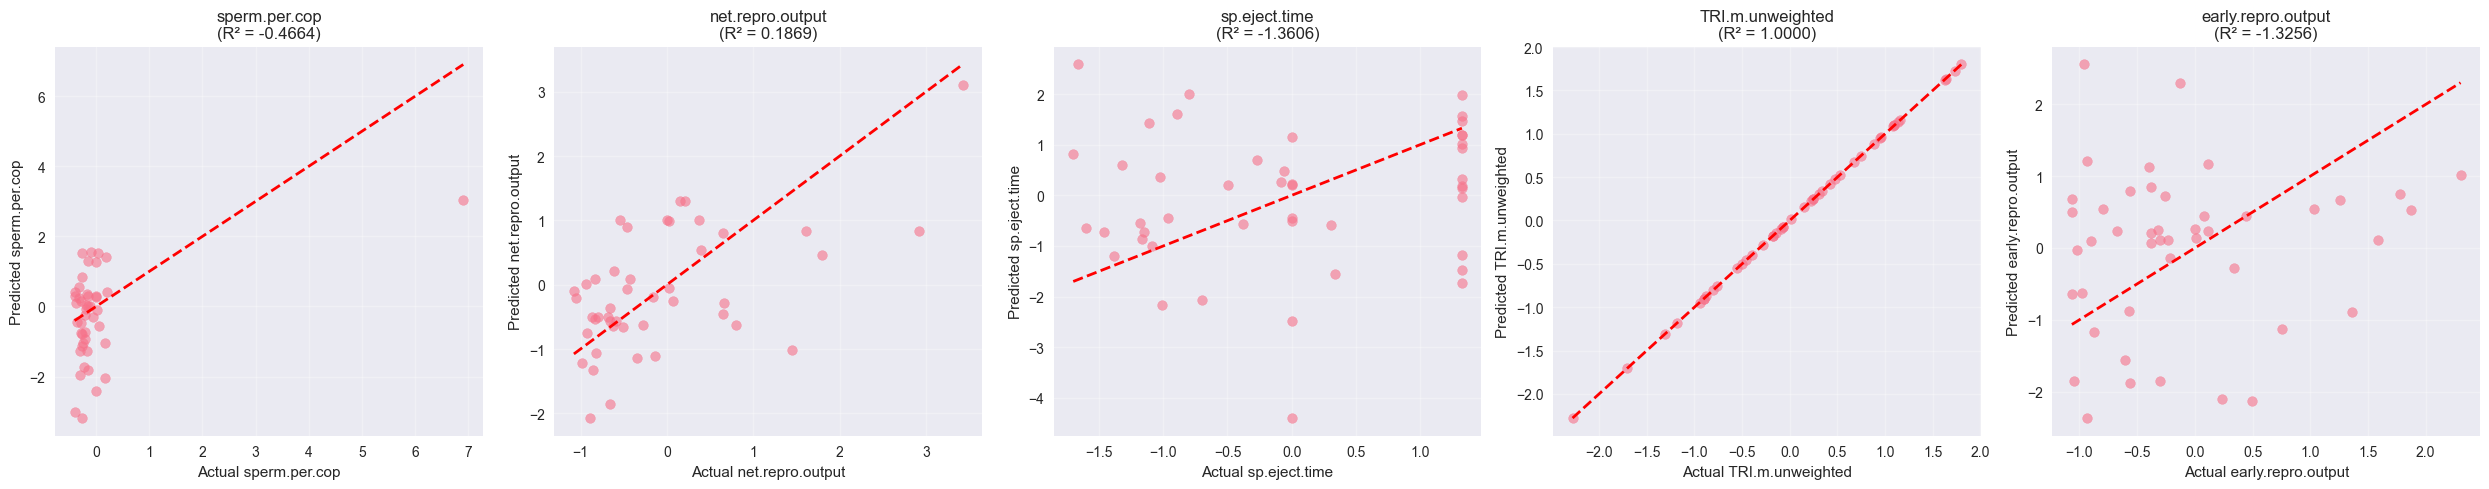


Average R² across 5 traits: -0.3932


In [8]:
# Multivariate Regression
print("Performing multivariate regression analysis...")

# Select multiple target traits (top 5 most variable traits)
trait_variability = X.std(axis=0)
top_variable_traits = trait_variability.nlargest(5).index.tolist()
target_indices = [trait_cols.index(trait) for trait in top_variable_traits]

# Prepare data: predict multiple traits from others
X_multi = X_scaled.copy()
y_multi = X_scaled[:, target_indices]

# Remove target traits from features
feature_indices = [i for i in range(X_scaled.shape[1]) if i not in target_indices]
X_multi_features = X_scaled[:, feature_indices]

# Split data
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_multi_features, y_multi, test_size=0.3, random_state=42
)

# Train multiple regression models (one per target trait)
multi_reg_models = []
r2_scores_multi = []

print(f"\nPredicting {len(target_indices)} traits simultaneously:")
for i, trait_name in enumerate(top_variable_traits):
    # Linear regression
    reg_model = LinearRegression()
    reg_model.fit(X_train_multi, y_train_multi[:, i])
    
    # Predictions
    y_pred_multi = reg_model.predict(X_test_multi)
    r2_score_multi = r2_score(y_test_multi[:, i], y_pred_multi)
    
    multi_reg_models.append(reg_model)
    r2_scores_multi.append(r2_score_multi)
    
    print(f"  {trait_name}: R² = {r2_score_multi:.4f}")

# Visualize multivariate regression results
fig, axes = plt.subplots(1, len(target_indices), figsize=(5*len(target_indices), 5))
if len(target_indices) == 1:
    axes = [axes]

for i, (trait_name, ax) in enumerate(zip(top_variable_traits, axes)):
    y_pred = multi_reg_models[i].predict(X_test_multi)
    ax.scatter(y_test_multi[:, i], y_pred, alpha=0.6)
    ax.plot([y_test_multi[:, i].min(), y_test_multi[:, i].max()], 
           [y_test_multi[:, i].min(), y_test_multi[:, i].max()], 'r--', lw=2)
    ax.set_xlabel(f'Actual {trait_name}')
    ax.set_ylabel(f'Predicted {trait_name}')
    ax.set_title(f'{trait_name}\n(R² = {r2_scores_multi[i]:.4f})')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage R² across {len(target_indices)} traits: {np.mean(r2_scores_multi):.4f}")


### 2.3 Decision Trees

Decision trees provide interpretable models and identify the most important traits for classification or regression.


Performing decision tree analysis...

Decision Tree Classification Accuracy: 0.8444

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        27
           1       0.82      0.78      0.80        18

    accuracy                           0.84        45
   macro avg       0.84      0.83      0.84        45
weighted avg       0.84      0.84      0.84        45



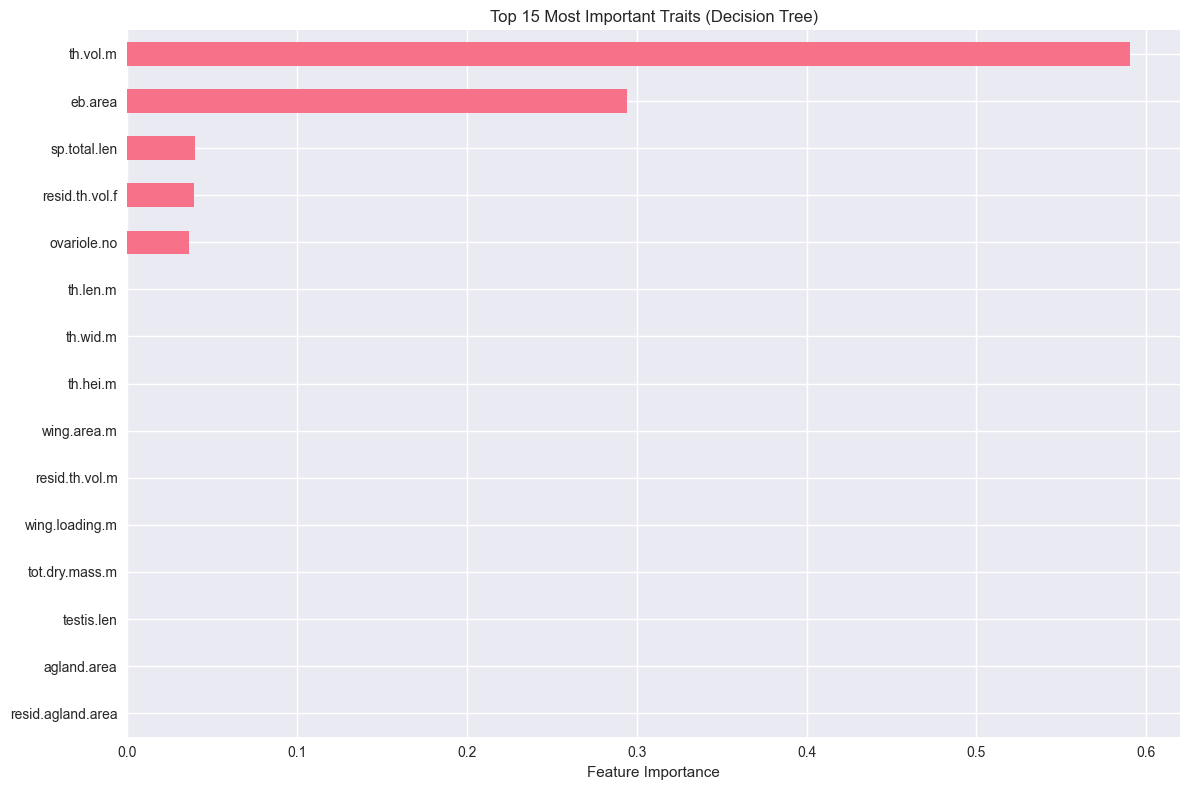


Top 10 Most Important Traits:
 1. th.vol.m: 0.5903
 2. eb.area: 0.2941
 3. sp.total.len: 0.0399
 4. resid.th.vol.f: 0.0395
 5. ovariole.no: 0.0361
 6. th.len.m: 0.0000
 7. th.wid.m: 0.0000
 8. th.hei.m: 0.0000
 9. wing.area.m: 0.0000
10. resid.th.vol.m: 0.0000

Decision Tree Regression R²: 0.8715


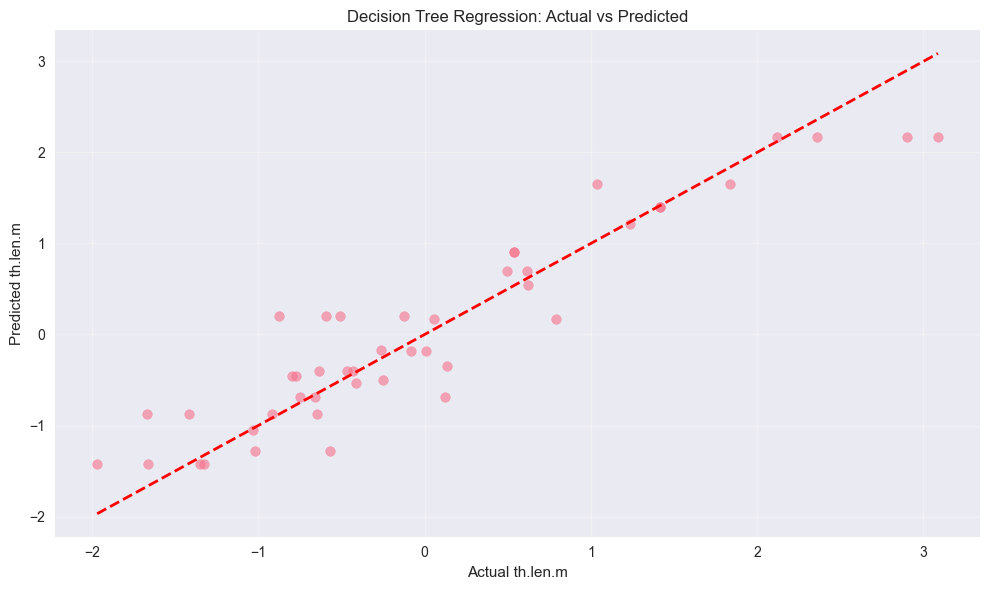

In [9]:
# Decision Trees - Classification and Feature Importance
print("Performing decision tree analysis...")

# Decision Tree Classifier
dt_classifier = DecisionTreeClassifier(max_depth=10, random_state=42, min_samples_split=5)
dt_classifier.fit(X_train, y_train)

y_pred_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, y_pred_dt)

print(f"\nDecision Tree Classification Accuracy: {accuracy_dt:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_dt))

# Feature importance from decision tree
feature_importance = pd.Series(dt_classifier.feature_importances_, index=trait_cols)
top_important_features = feature_importance.nlargest(15)

# Plot feature importance
plt.figure(figsize=(12, 8))
top_important_features.plot(kind='barh')
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Traits (Decision Tree)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Traits:")
for i, (trait, importance) in enumerate(top_important_features.head(10).items(), 1):
    print(f"{i:2d}. {trait}: {importance:.4f}")

# Decision Tree Regressor
dt_regressor = DecisionTreeRegressor(max_depth=10, random_state=42, min_samples_split=5)
dt_regressor.fit(X_train_reg, y_train_reg)

y_pred_dt_reg = dt_regressor.predict(X_test_reg)
r2_dt_reg = r2_score(y_test_reg, y_pred_dt_reg)

print(f"\nDecision Tree Regression R²: {r2_dt_reg:.4f}")

# Visualize decision tree regression
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_dt_reg, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel(f'Actual {target_trait_name}')
plt.ylabel(f'Predicted {target_trait_name}')
plt.title(f'Decision Tree Regression: Actual vs Predicted')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 2.4 Time Series Analysis

Time series analysis can model trait evolution across species using phylogenetic order or species relationships as a proxy for evolutionary time.


Performing time series analysis...


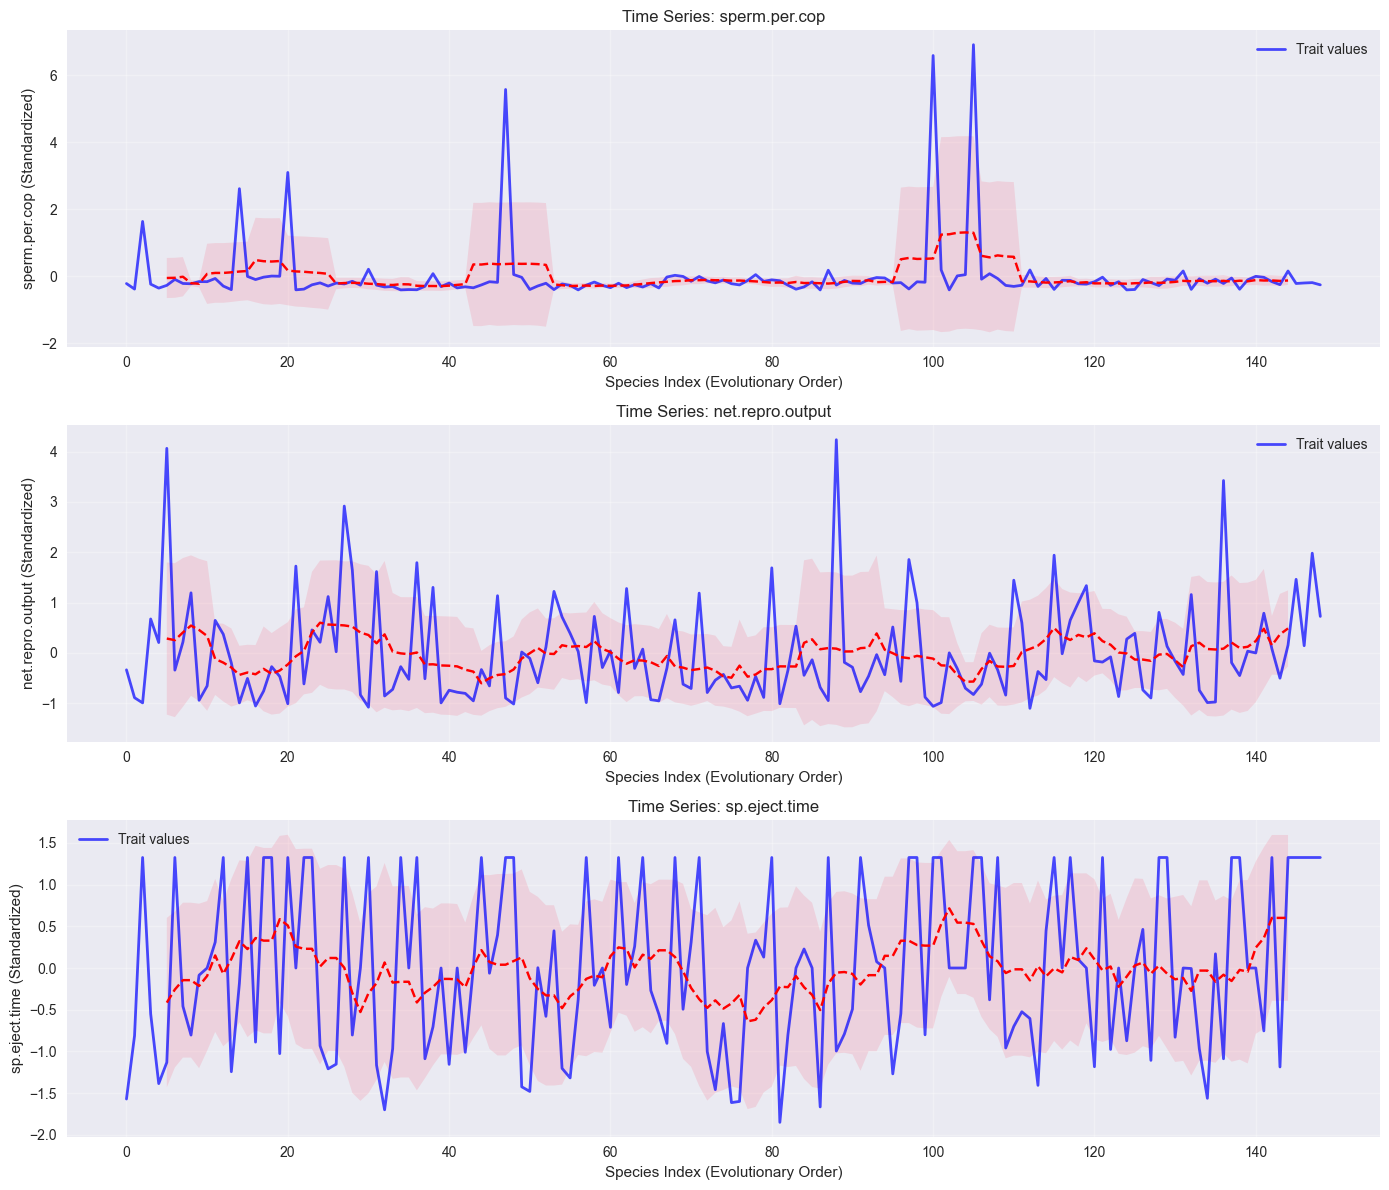


Autocorrelation Analysis (measuring trait persistence across species):


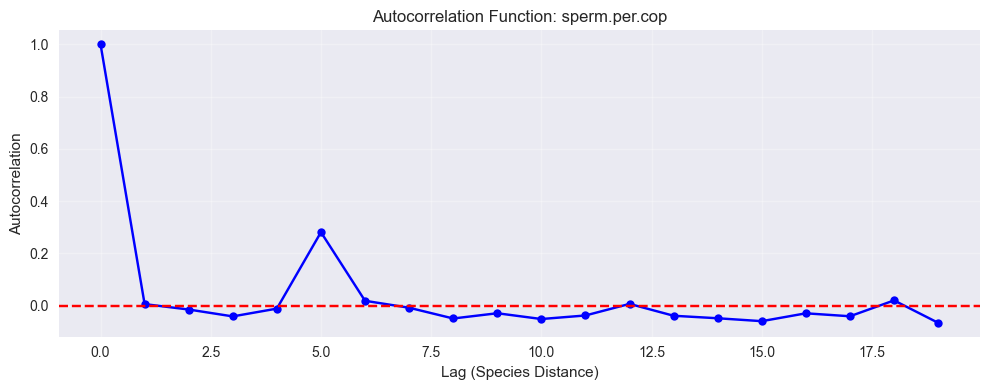

  sperm.per.cop: Lag-1 autocorrelation = 0.006


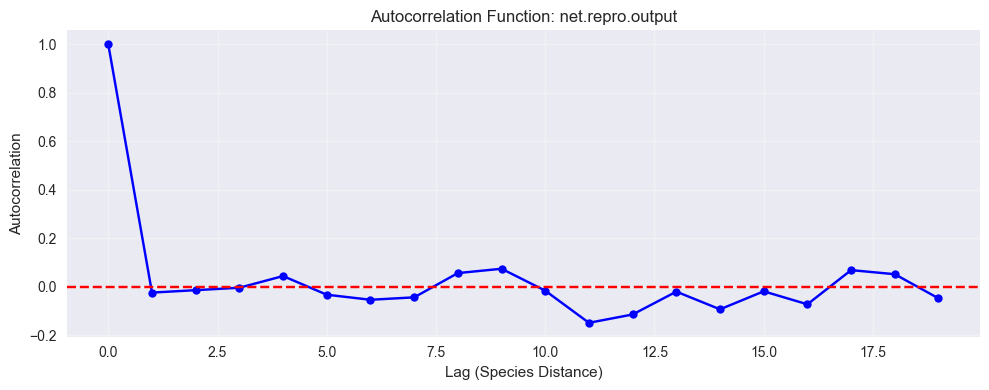

  net.repro.output: Lag-1 autocorrelation = -0.025


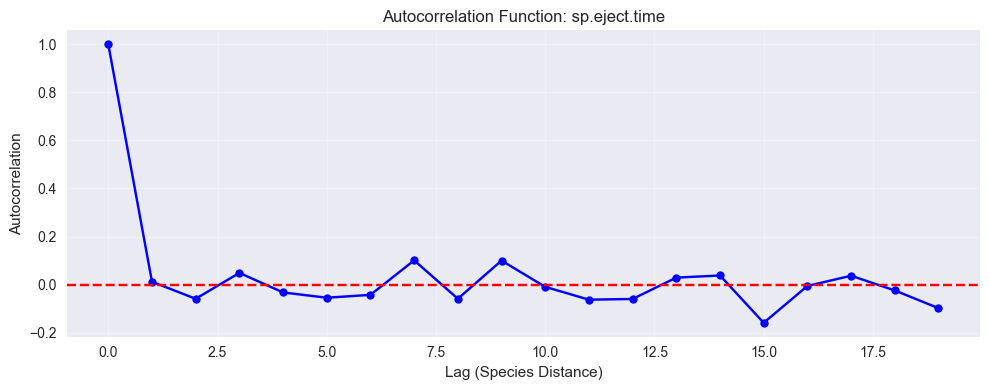

  sp.eject.time: Lag-1 autocorrelation = 0.012

Time series analysis complete. This reveals how traits persist or vary across evolutionary relationships.


In [10]:
# Time Series Analysis
print("Performing time series analysis...")

# Use trait values as time series (ordered by species or phylogenetic relationships)
# For this analysis, we'll treat species order as a proxy for evolutionary progression
# Select a few key traits for time series analysis
key_traits_for_ts = top_variable_traits[:3] if len(top_variable_traits) >= 3 else trait_cols[:3]

# Create time series data (species order as time index)
time_index = np.arange(len(species_names))
time_series_data = {}

fig, axes = plt.subplots(len(key_traits_for_ts), 1, figsize=(14, 4*len(key_traits_for_ts)))
if len(key_traits_for_ts) == 1:
    axes = [axes]

for idx, trait_name in enumerate(key_traits_for_ts):
    trait_idx = trait_cols.index(trait_name)
    trait_values = X_scaled[:, trait_idx]
    
    # Store time series
    time_series_data[trait_name] = trait_values
    
    # Plot time series
    ax = axes[idx]
    ax.plot(time_index, trait_values, 'b-', alpha=0.7, linewidth=2, label='Trait values')
    ax.set_xlabel('Species Index (Evolutionary Order)')
    ax.set_ylabel(f'{trait_name} (Standardized)')
    ax.set_title(f'Time Series: {trait_name}')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Calculate rolling mean and std
    window = min(10, len(trait_values) // 5)
    if window > 1:
        rolling_mean = pd.Series(trait_values).rolling(window=window, center=True).mean()
        rolling_std = pd.Series(trait_values).rolling(window=window, center=True).std()
        ax.plot(time_index, rolling_mean, 'r--', label=f'Rolling Mean (window={window})')
        ax.fill_between(time_index, 
                        rolling_mean - rolling_std, 
                        rolling_mean + rolling_std, 
                        alpha=0.2, label='Rolling Std')

plt.tight_layout()
plt.show()

# Autocorrelation analysis
print("\nAutocorrelation Analysis (measuring trait persistence across species):")
for trait_name in key_traits_for_ts:
    trait_values = time_series_data[trait_name]
    
    # Calculate autocorrelation
    from scipy.signal import correlate
    autocorr = np.correlate(trait_values - trait_values.mean(), 
                           trait_values - trait_values.mean(), mode='full')
    autocorr = autocorr[len(autocorr)//2:]
    autocorr = autocorr / autocorr[0]  # Normalize
    
    # Plot autocorrelation for first 20 lags
    lags = np.arange(min(20, len(autocorr)))
    plt.figure(figsize=(10, 4))
    plt.plot(lags, autocorr[:len(lags)], 'bo-', markersize=6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Lag (Species Distance)')
    plt.ylabel('Autocorrelation')
    plt.title(f'Autocorrelation Function: {trait_name}')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print(f"  {trait_name}: Lag-1 autocorrelation = {autocorr[1]:.3f}")

print("\nTime series analysis complete. This reveals how traits persist or vary across evolutionary relationships.")


## Part 3: Statistical Validation - Validating Evolutionary Hypotheses

Advanced statistical methods to validate evolutionary hypotheses and identify significant trait relationships.


### 3.1 LASSO Regression

LASSO regression performs feature selection while fitting the model, identifying the most important traits for prediction.


Performing LASSO regression analysis...
Optimal LASSO regularization parameter (alpha): 0.000518

LASSO Regression Performance:
  R²: 0.9953
  RMSE: 0.0819
  Selected features: 49/69 (71.0%)


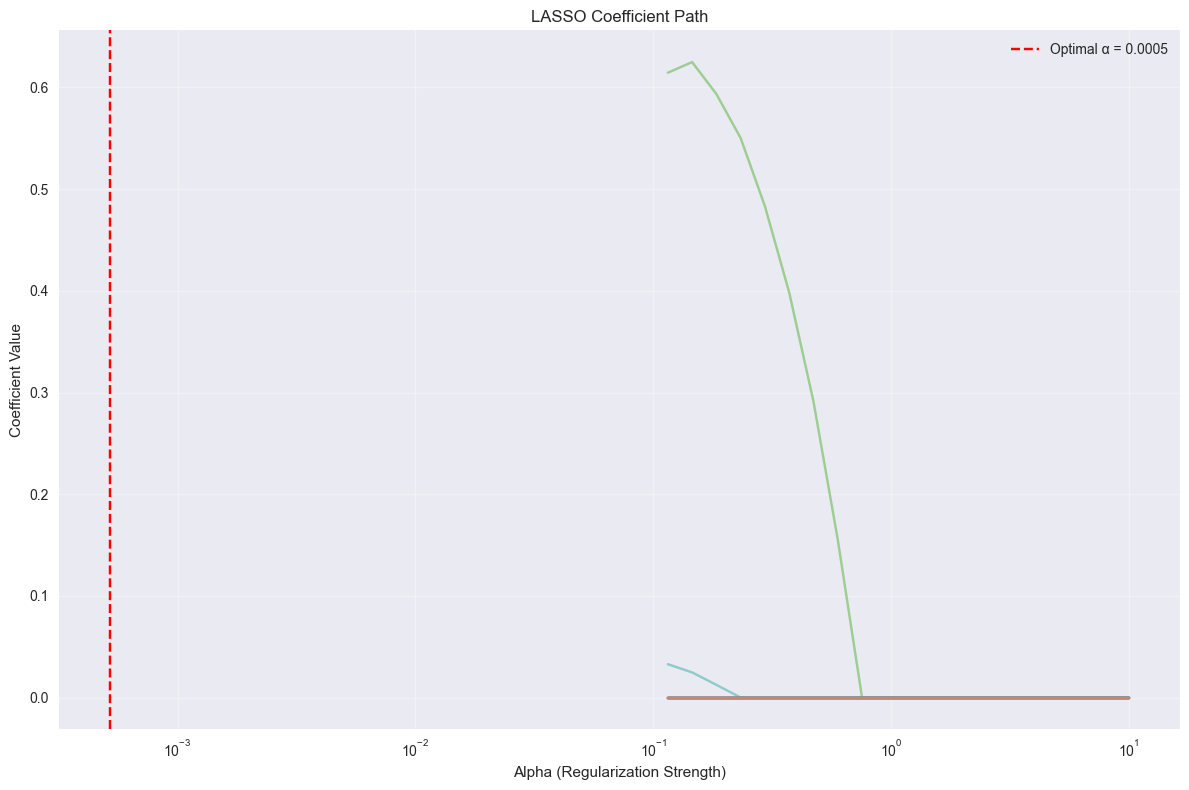

ValueError: Length of values (69) does not match length of index (65)

In [11]:
# LASSO Regression with Cross-Validation
print("Performing LASSO regression analysis...")

# Use same regression setup as before
# LASSO with cross-validation to find optimal alpha
lasso_cv = LassoCV(alphas=np.logspace(-4, 1, 50), cv=5, random_state=42, max_iter=2000)
lasso_cv.fit(X_train_reg, y_train_reg)

optimal_alpha = lasso_cv.alpha_
print(f"Optimal LASSO regularization parameter (alpha): {optimal_alpha:.6f}")

# Fit LASSO with optimal alpha
lasso_model = Lasso(alpha=optimal_alpha, max_iter=2000, random_state=42)
lasso_model.fit(X_train_reg, y_train_reg)

# Predictions
y_pred_lasso = lasso_model.predict(X_test_reg)
r2_lasso = r2_score(y_test_reg, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test_reg, y_pred_lasso))

print(f"\nLASSO Regression Performance:")
print(f"  R²: {r2_lasso:.4f}")
print(f"  RMSE: {rmse_lasso:.4f}")

# Count non-zero coefficients (selected features)
n_selected_features = np.sum(lasso_model.coef_ != 0)
total_features = len(lasso_model.coef_)
print(f"  Selected features: {n_selected_features}/{total_features} ({100*n_selected_features/total_features:.1f}%)")

# Plot coefficient path (showing how coefficients change with alpha)
alphas = lasso_cv.alphas_
coefs_path = []

for alpha in alphas[:20]:  # Use first 20 for visualization
    lasso_temp = Lasso(alpha=alpha, max_iter=2000)
    lasso_temp.fit(X_train_reg, y_train_reg)
    coefs_path.append(lasso_temp.coef_)

coefs_path = np.array(coefs_path)

# Plot coefficient path
plt.figure(figsize=(12, 8))
for i in range(min(20, coefs_path.shape[1])):  # Plot first 20 features
    plt.plot(alphas[:20], coefs_path[:, i], alpha=0.5)
plt.axvline(x=optimal_alpha, color='r', linestyle='--', label=f'Optimal α = {optimal_alpha:.4f}')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Coefficient Value')
plt.title('LASSO Coefficient Path')
plt.xscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Identify selected features
selected_features = pd.Series(lasso_model.coef_, 
                             index=[trait_cols[i] for i in feature_indices])
selected_features = selected_features[selected_features != 0].sort_values(key=abs, ascending=False)

print("\nTop 10 Selected Features (Non-zero coefficients):")
for i, (trait, coef) in enumerate(selected_features.head(10).items(), 1):
    print(f"{i:2d}. {trait}: {coef:.4f}")

# Visualize LASSO predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_lasso, alpha=0.6)
plt.plot([y_test_reg.min(), y_test_reg.max()], 
         [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel(f'Actual {target_trait_name}')
plt.ylabel(f'Predicted {target_trait_name}')
plt.title(f'LASSO Regression: Actual vs Predicted')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


### 3.2 Naive Bayes Classification

Naive Bayes provides probabilistic classification of species into evolutionary syndromes, useful for hypothesis validation.


Performing Naive Bayes classification analysis...
Naive Bayes Classification Accuracy: 0.9111

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.92        27
           1       0.85      0.94      0.89        18

    accuracy                           0.91        45
   macro avg       0.91      0.92      0.91        45
weighted avg       0.92      0.91      0.91        45



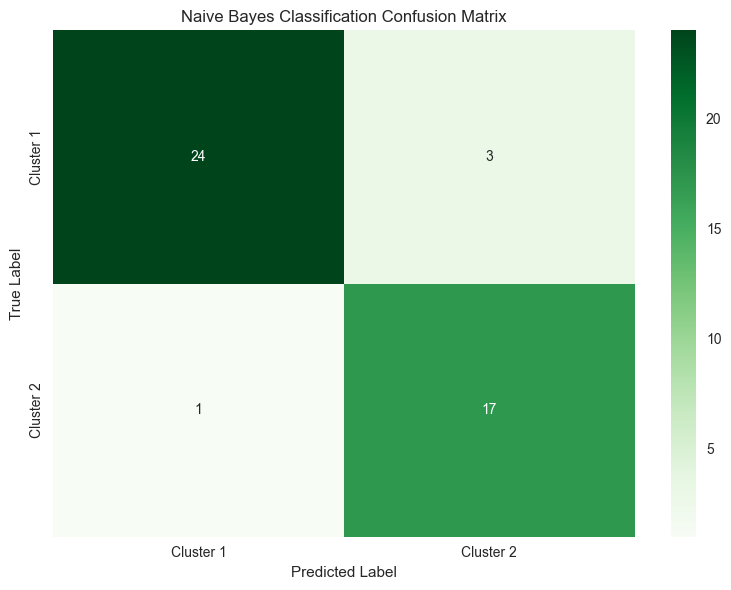


Sample Predictions (showing probability distributions):

Sample 2:
  True cluster: 1, Predicted cluster: 1
  Probabilities: {0: np.float64(0.0), 1: np.float64(1.0)}
  Confidence: 1.0000

Sample 23:
  True cluster: 0, Predicted cluster: 0
  Probabilities: {0: np.float64(1.0), 1: np.float64(0.0)}
  Confidence: 1.0000

Sample 44:
  True cluster: 0, Predicted cluster: 0
  Probabilities: {0: np.float64(0.9989), 1: np.float64(0.0011)}
  Confidence: 0.9989

Sample 40:
  True cluster: 0, Predicted cluster: 1
  Probabilities: {0: np.float64(0.4832), 1: np.float64(0.5168)}
  Confidence: 0.5168

Sample 37:
  True cluster: 1, Predicted cluster: 1
  Probabilities: {0: np.float64(0.0), 1: np.float64(1.0)}
  Confidence: 1.0000

Trait Variance Analysis by Cluster (from Naive Bayes):

Cluster 1 (most variable traits):
  sperm.per.cop: 2.1357
  anisogamy: 1.5122
  spth.melanized_bin: 1.2810
  egg.wid.mean: 1.2667
  egg.vol: 1.2247

Cluster 2 (most variable traits):
  eb.extn.len: 2.6920
  eb.extn.branc

In [12]:
# Naive Bayes Classification
print("Performing Naive Bayes classification analysis...")

# Train Naive Bayes classifier
nb_classifier = GaussianNB()
nb_classifier.fit(X_train, y_train)

# Predictions
y_pred_nb = nb_classifier.predict(X_test)
y_pred_proba_nb = nb_classifier.predict_proba(X_test)

# Evaluate
accuracy_nb = accuracy_score(y_test, y_pred_nb)

print(f"Naive Bayes Classification Accuracy: {accuracy_nb:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_nb))

# Confusion matrix
plt.figure(figsize=(8, 6))
cm_nb = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Greens', 
           xticklabels=[f'Cluster {i+1}' for i in range(optimal_k)],
           yticklabels=[f'Cluster {i+1}' for i in range(optimal_k)])
plt.title('Naive Bayes Classification Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Show class probabilities for a few test samples
print("\nSample Predictions (showing probability distributions):")
sample_indices = np.random.choice(len(X_test), size=min(5, len(X_test)), replace=False)
for idx in sample_indices:
    true_label = y_test[idx]
    pred_label = y_pred_nb[idx]
    probabilities = y_pred_proba_nb[idx]
    print(f"\nSample {idx}:")
    print(f"  True cluster: {true_label}, Predicted cluster: {pred_label}")
    print(f"  Probabilities: {dict(zip(range(optimal_k), probabilities.round(4)))}")
    print(f"  Confidence: {probabilities[pred_label]:.4f}")

# Analyze feature importance (variance per class)
print("\nTrait Variance Analysis by Cluster (from Naive Bayes):")
for i in range(optimal_k):
    cluster_mask = y_train == i
    if np.sum(cluster_mask) > 0:
        cluster_vars = X_train[cluster_mask].var(axis=0)
        top_variable_traits = pd.Series(cluster_vars, index=trait_cols).nlargest(5)
        print(f"\nCluster {i+1} (most variable traits):")
        for trait, var_val in top_variable_traits.items():
            print(f"  {trait}: {var_val:.4f}")


### 3.3 Correlation Tests

Statistical correlation tests validate relationships between traits, testing evolutionary hypotheses about trait co-evolution.


Performing correlation analysis...


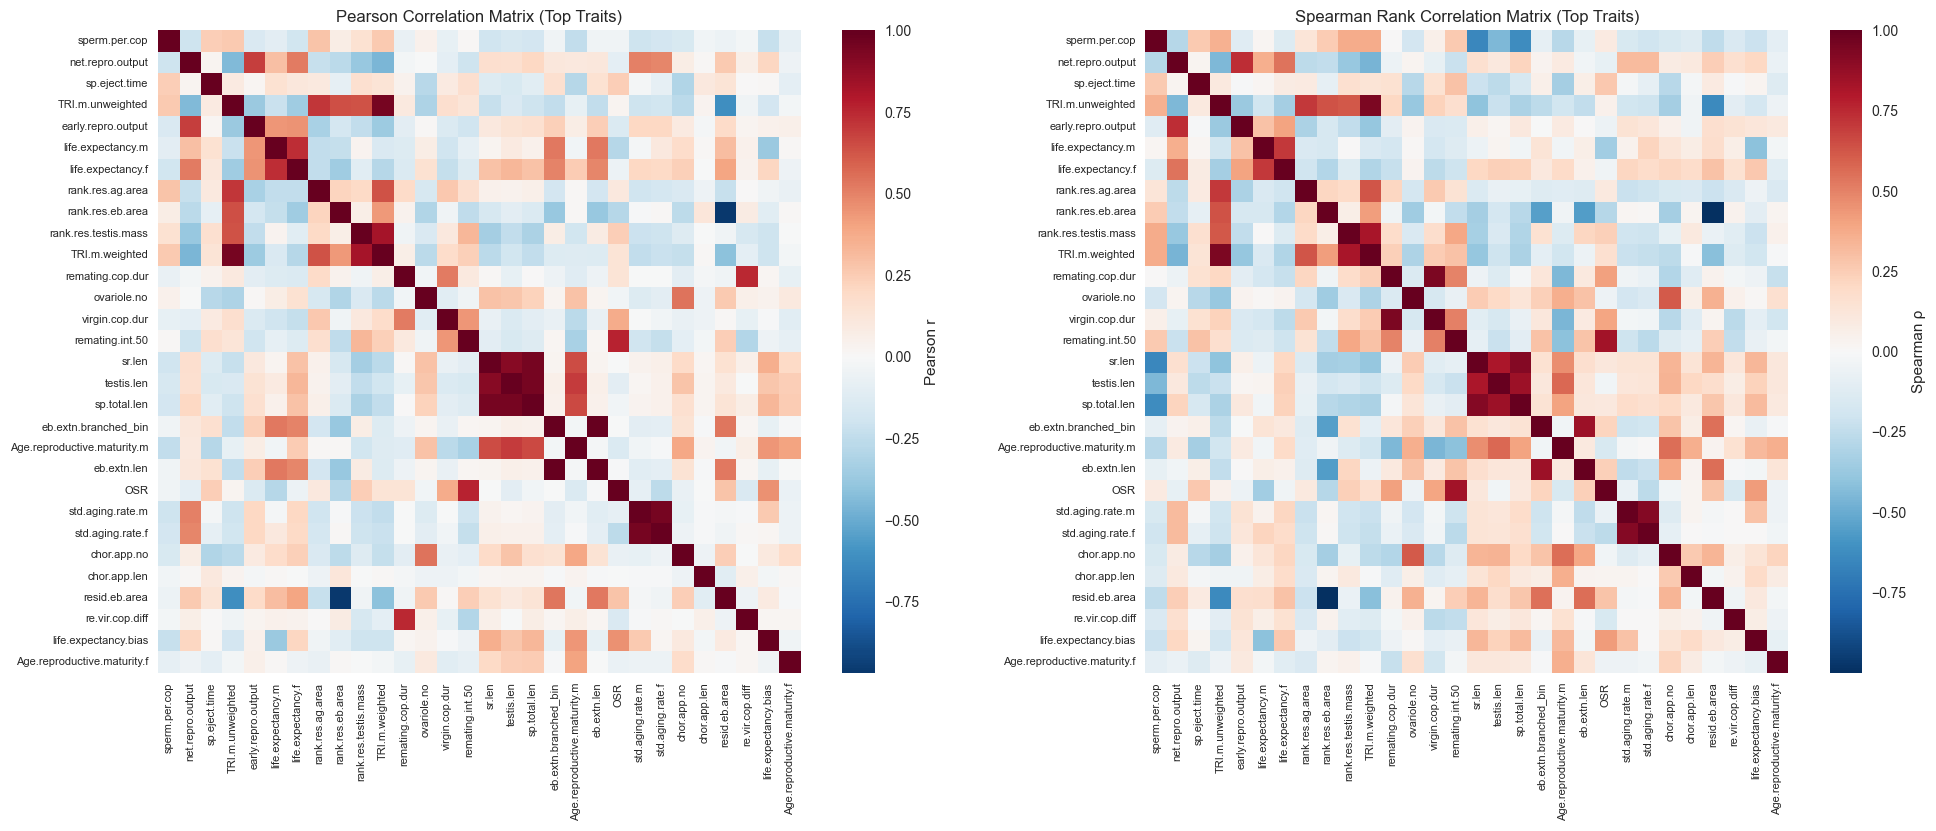


Top 10 Strongest Positive Correlations (Pearson):
 1. eb.extn.branched_bin <-> eb.extn.len: r = 0.9985
 2. rank.res.eb.area <-> resid.eb.area: r = -0.9680
 3. TRI.m.unweighted <-> TRI.m.weighted: r = 0.9535
 4. sr.len <-> sp.total.len: r = 0.9534
 5. testis.len <-> sp.total.len: r = 0.9485
 6. std.aging.rate.m <-> std.aging.rate.f: r = 0.9482
 7. sr.len <-> testis.len: r = 0.9024
 8. rank.res.testis.mass <-> TRI.m.weighted: r = 0.8269
 9. remating.int.50 <-> OSR: r = 0.7693
10. remating.cop.dur <-> re.vir.cop.diff: r = 0.7507


Statistical Significance Testing (p-values < 0.05):
Found 239 significantly correlated pairs

Top 10 Significant Correlations:
Trait 1                        Trait 2                        Pearson r    p-value    Spearman ρ  
----------------------------------------------------------------------------------------------------
eb.extn.branched_bin           eb.extn.len                      0.9985  *   0.0000   0.8547  *
rank.res.eb.area               resid.eb.are

In [13]:
# Correlation Tests - Pearson and Spearman
print("Performing correlation analysis...")

# Select top traits for correlation analysis (reduce computation)
n_traits_for_corr = min(30, len(trait_cols))
top_traits_for_corr = trait_variability.nlargest(n_traits_for_corr).index.tolist()
corr_indices = [trait_cols.index(trait) for trait in top_traits_for_corr]

# Calculate correlation matrices
pearson_corr = np.corrcoef(X_scaled[:, corr_indices].T)
spearman_corr, spearman_p = spearmanr(X_scaled[:, corr_indices])

# Create correlation dataframes
pearson_df = pd.DataFrame(pearson_corr, index=top_traits_for_corr, columns=top_traits_for_corr)
spearman_df = pd.DataFrame(spearman_corr, index=top_traits_for_corr, columns=top_traits_for_corr)

# Visualize correlation matrices
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Pearson correlation
sns.heatmap(pearson_df, annot=False, cmap='RdBu_r', center=0, 
           square=True, fmt='.2f', ax=axes[0], cbar_kws={'label': 'Pearson r'})
axes[0].set_title('Pearson Correlation Matrix (Top Traits)')
axes[0].tick_params(axis='both', labelsize=8)

# Spearman correlation
sns.heatmap(spearman_df, annot=False, cmap='RdBu_r', center=0, 
           square=True, fmt='.2f', ax=axes[1], cbar_kws={'label': 'Spearman ρ'})
axes[1].set_title('Spearman Rank Correlation Matrix (Top Traits)')
axes[1].tick_params(axis='both', labelsize=8)

plt.tight_layout()
plt.show()

# Find strongly correlated trait pairs
print("\nTop 10 Strongest Positive Correlations (Pearson):")
corr_pairs = []
for i in range(len(top_traits_for_corr)):
    for j in range(i+1, len(top_traits_for_corr)):
        corr_value = pearson_corr[i, j]
        corr_pairs.append((top_traits_for_corr[i], top_traits_for_corr[j], corr_value))

# Sort by absolute correlation
corr_pairs_sorted = sorted(corr_pairs, key=lambda x: abs(x[2]), reverse=True)

for i, (trait1, trait2, corr) in enumerate(corr_pairs_sorted[:10], 1):
    print(f"{i:2d}. {trait1} <-> {trait2}: r = {corr:.4f}")

# Statistical significance testing
print("\n\nStatistical Significance Testing (p-values < 0.05):")
significant_pairs = []
for i in range(len(top_traits_for_corr)):
    for j in range(i+1, len(top_traits_for_corr)):
        # Pearson correlation test
        pearson_r, pearson_p = pearsonr(X_scaled[:, corr_indices[i]], 
                                        X_scaled[:, corr_indices[j]])
        # Spearman correlation test
        spearman_r, spearman_p_val = spearmanr(X_scaled[:, corr_indices[i]], 
                                               X_scaled[:, corr_indices[j]])
        
        if pearson_p < 0.05 or spearman_p_val < 0.05:
            significant_pairs.append((
                top_traits_for_corr[i], 
                top_traits_for_corr[j], 
                pearson_r, pearson_p, 
                spearman_r, spearman_p_val
            ))

# Sort by correlation strength
significant_pairs_sorted = sorted(significant_pairs, 
                               key=lambda x: abs(x[2]), reverse=True)

print(f"Found {len(significant_pairs_sorted)} significantly correlated pairs\n")
print("Top 10 Significant Correlations:")
print(f"{'Trait 1':<30} {'Trait 2':<30} {'Pearson r':<12} {'p-value':<10} {'Spearman ρ':<12}")
print("-" * 100)

for trait1, trait2, r_pearson, p_pearson, r_spearman, p_spearman in significant_pairs_sorted[:10]:
    sig_pearson = "*" if p_pearson < 0.05 else ""
    sig_spearman = "*" if p_spearman < 0.05 else ""
    print(f"{trait1[:29]:<30} {trait2[:29]:<30} {r_pearson:>8.4f}{sig_pearson:>3} {p_pearson:>8.4f} {r_spearman:>8.4f}{sig_spearman:>3}")

print("\n* indicates p < 0.05")


## Summary: Model Performance and Key Findings

Summary of all models and their performance in identifying evolutionary trait dependencies.
